# Phân tích dữ liệu covid19
    Nguyễn Phúc Khôi Nguyên      1712106
    Nguyễn Thành Nhân            1712631
    Nguyễn Huỳnh Minh Thuận      1712175

In [38]:
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
PATH = "data\\covid_19_data.csv"
PATH_CONFIRM = "data\\time_series_covid_19_confirmed.csv"
PATH_DEATHS = "data\\time_series_covid_19_deaths.csv"
PATH_RECOVERED = "data\\time_series_covid_19_recovered.csv"

In [40]:
data = pd.read_csv(PATH)
confirmed_df = pd.read_csv(PATH_CONFIRM)
deaths_df = pd.read_csv(PATH_DEATHS)
recovered_df = pd.read_csv(PATH_RECOVERED)

In [41]:
data = data.drop("SNo", axis=1)
data = data.drop("Last Update", axis=1)

data.head(10)

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0
5,01/22/2020,Guangdong,Mainland China,26.0,0.0,0.0
6,01/22/2020,Guangxi,Mainland China,2.0,0.0,0.0
7,01/22/2020,Guizhou,Mainland China,1.0,0.0,0.0
8,01/22/2020,Hainan,Mainland China,4.0,0.0,0.0
9,01/22/2020,Hebei,Mainland China,1.0,0.0,0.0


Xét thông tin ca nhiễm trên một quốc gia

In [42]:
nation = "Italy"
data_1 = data[data["Country/Region"] == nation].reset_index(drop=True)

data_1 = data_1.drop("Province/State", axis=1)
# data_1 = data.drop("Province/State", axis=1)

#Mot so quốc gia được chia theo vùng, một số không, do đó tổng hợp số ca theo ngày trên cả quốc gia
data_1 = data_1.groupby("ObservationDate").agg("sum").reset_index()

data_1.head(10)

,ObservationDate,Confirmed,Deaths,Recovered
0,01/31/2020,2.0,0.0,0.0
1,02/01/2020,2.0,0.0,0.0
2,02/02/2020,2.0,0.0,0.0
3,02/03/2020,2.0,0.0,0.0
4,02/04/2020,2.0,0.0,0.0
5,02/05/2020,2.0,0.0,0.0
6,02/06/2020,2.0,0.0,0.0
7,02/07/2020,3.0,0.0,0.0
8,02/08/2020,3.0,0.0,0.0
9,02/09/2020,3.0,0.0,0.0


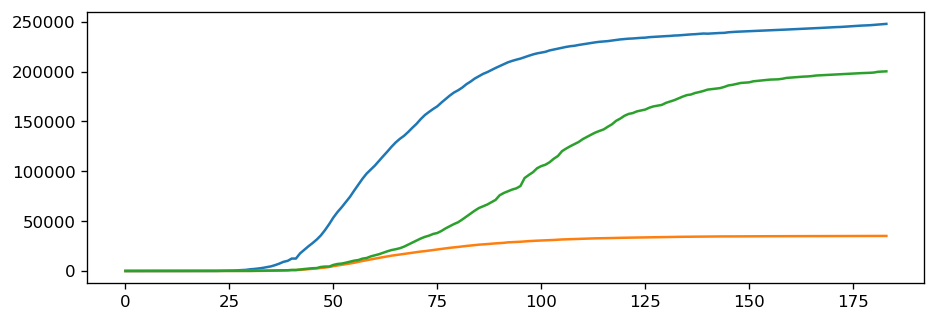

In [43]:
plt.plot(data_1["Confirmed"])
plt.plot(data_1["Deaths"])
plt.plot(data_1["Recovered"]);

### Nhận xét
Số lượng ca mắc, hồi phục và tử vong là các chỉ số luôn tăng theo thời gian, do đó khả năng cao là non-stationary không phù hợp với các mô hình dự báo, tính toán thông tin "Số ca đang mắc" = số ca mắc - số ca tử vong - số ca hồi phục và số ca mới là hiệu số ca mắc sau mỗi ngày.

Mô hình dự đoán được xây dựng dựa trên số ca mới

Tham khảo về stationarity: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

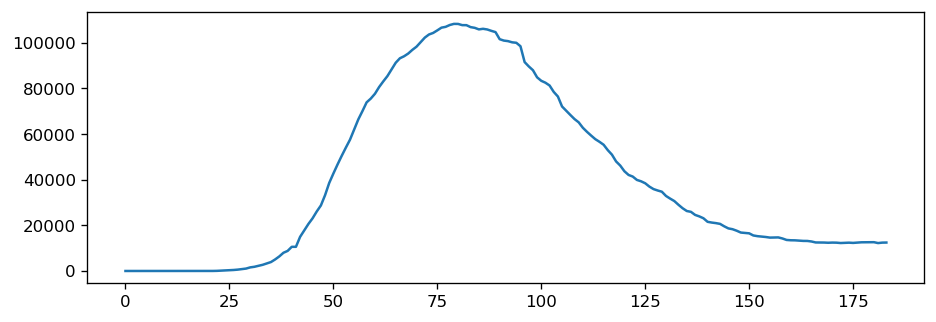

In [44]:
data_1["Active"] = data_1["Confirmed"] - data_1["Recovered"] - data_1["Deaths"]
#Số ca mới
plt.plot(data_1["Active"]);

Ta có p-value = 0.83 > 0.05, như vậy dữ liệu số ca mắc ở VN là non-stationary (phụ thuộc vào biến thời gian)

In [45]:
from statsmodels.tsa.stattools import adfuller

df = data_1[["Active"]].copy()
df = df.reset_index(drop=True)

result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.060551
p-value: 0.001125


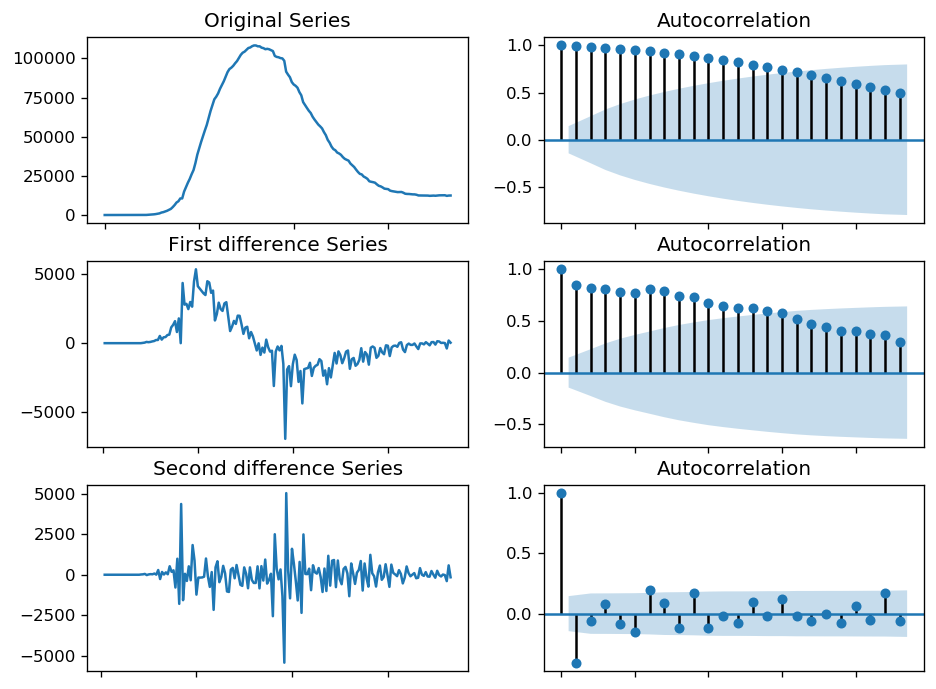

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(9, 7), sharex=False)

axes[0, 0].plot(df); axes[0, 0].set_title('Original Series'); axes[0, 0].set_xticklabels([])
plot_acf(df, ax=axes[0, 1]); axes[0, 1].set_xticklabels([])

axes[1, 0].plot(df.diff()); axes[1, 0].set_title('First difference Series'); axes[1, 0].set_xticklabels([])
plot_acf(df.diff().dropna(), ax=axes[1, 1]); axes[1, 1].set_xticklabels([])

axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('Second difference Series'); axes[2, 0].set_xticklabels([])
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1]); axes[2, 1].set_xticklabels([])

plt.show()

In [47]:
temp = df.diff().diff().dropna()
result = adfuller(temp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.016937
p-value: 0.001324


Như vậy chọn mô hình arima có tham số d = 2

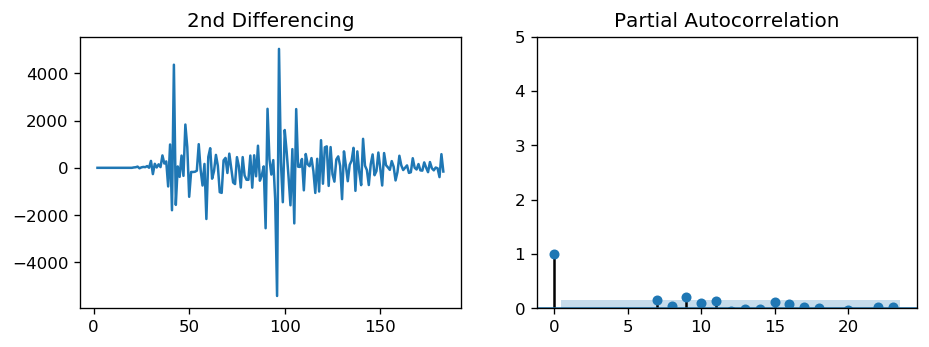

In [48]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(temp); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(temp.dropna(), ax=axes[1])

plt.show()

Chọn p = 1

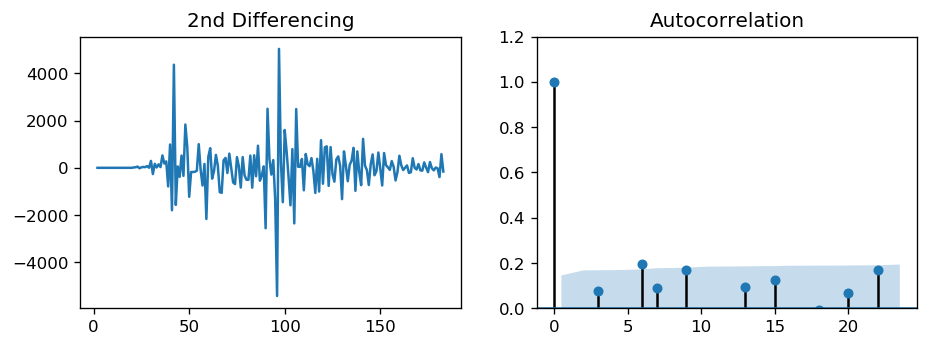

In [49]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2)
axes[0].plot(temp); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(temp.dropna(), ax=axes[1])

plt.show()

Chọn q = 1

In [50]:
print(df.shape)
n = 40

train = df.iloc[:-n]
test  = df.iloc[-n:]

print(train.shape)
print(test.shape)

(184, 1)
(144, 1)
(40, 1)


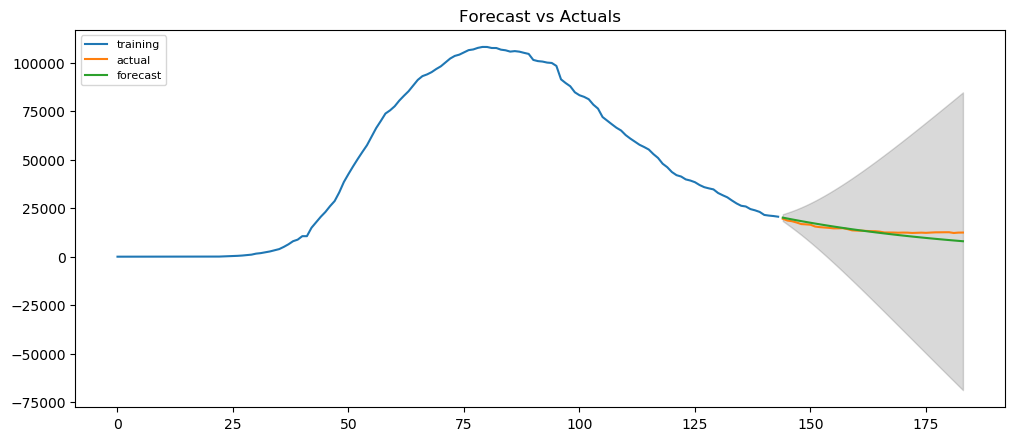

In [51]:
from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train, order=(2,1,1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(n, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Thống kê các trường hợp mới mắc Covid19 theo tháng

In [52]:
data = pd.read_csv("data/time_series_covid_19_confirmed.csv")
data.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,35928,35981,36036,36157,36263,36368,36471,36542,36675,36710
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,4466,4570,4637,4763,4880,4997,5105,5197,5276,5396
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,25484,26159,26764,27357,27973,28615,29229,29831,30394,30950
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,889,897,897,897,907,907,918,922,925,925
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,851,880,916,932,950,1000,1078,1109,1148,1164
5,NaN,Antigua and Barbuda,17.06080,-61.796400,0,0,0,0,0,0,...,76,82,82,82,86,86,91,91,91,91
6,NaN,Argentina,-38.41610,-63.616700,0,0,0,0,0,0,...,148027,153520,158334,162526,167416,173355,178996,185373,191302,196543
7,NaN,Armenia,40.06910,45.038200,0,0,0,0,0,0,...,36162,36613,36996,37317,37390,37629,37937,38196,38550,38841
8,Australian Capital Territory,Australia,-35.47350,149.012400,0,0,0,0,0,0,...,113,113,113,113,113,113,113,113,113,113
9,New South Wales,Australia,-33.86880,151.209300,0,0,0,0,3,4,...,3640,3654,3668,3685,3699,3718,3736,3756,3773,3784


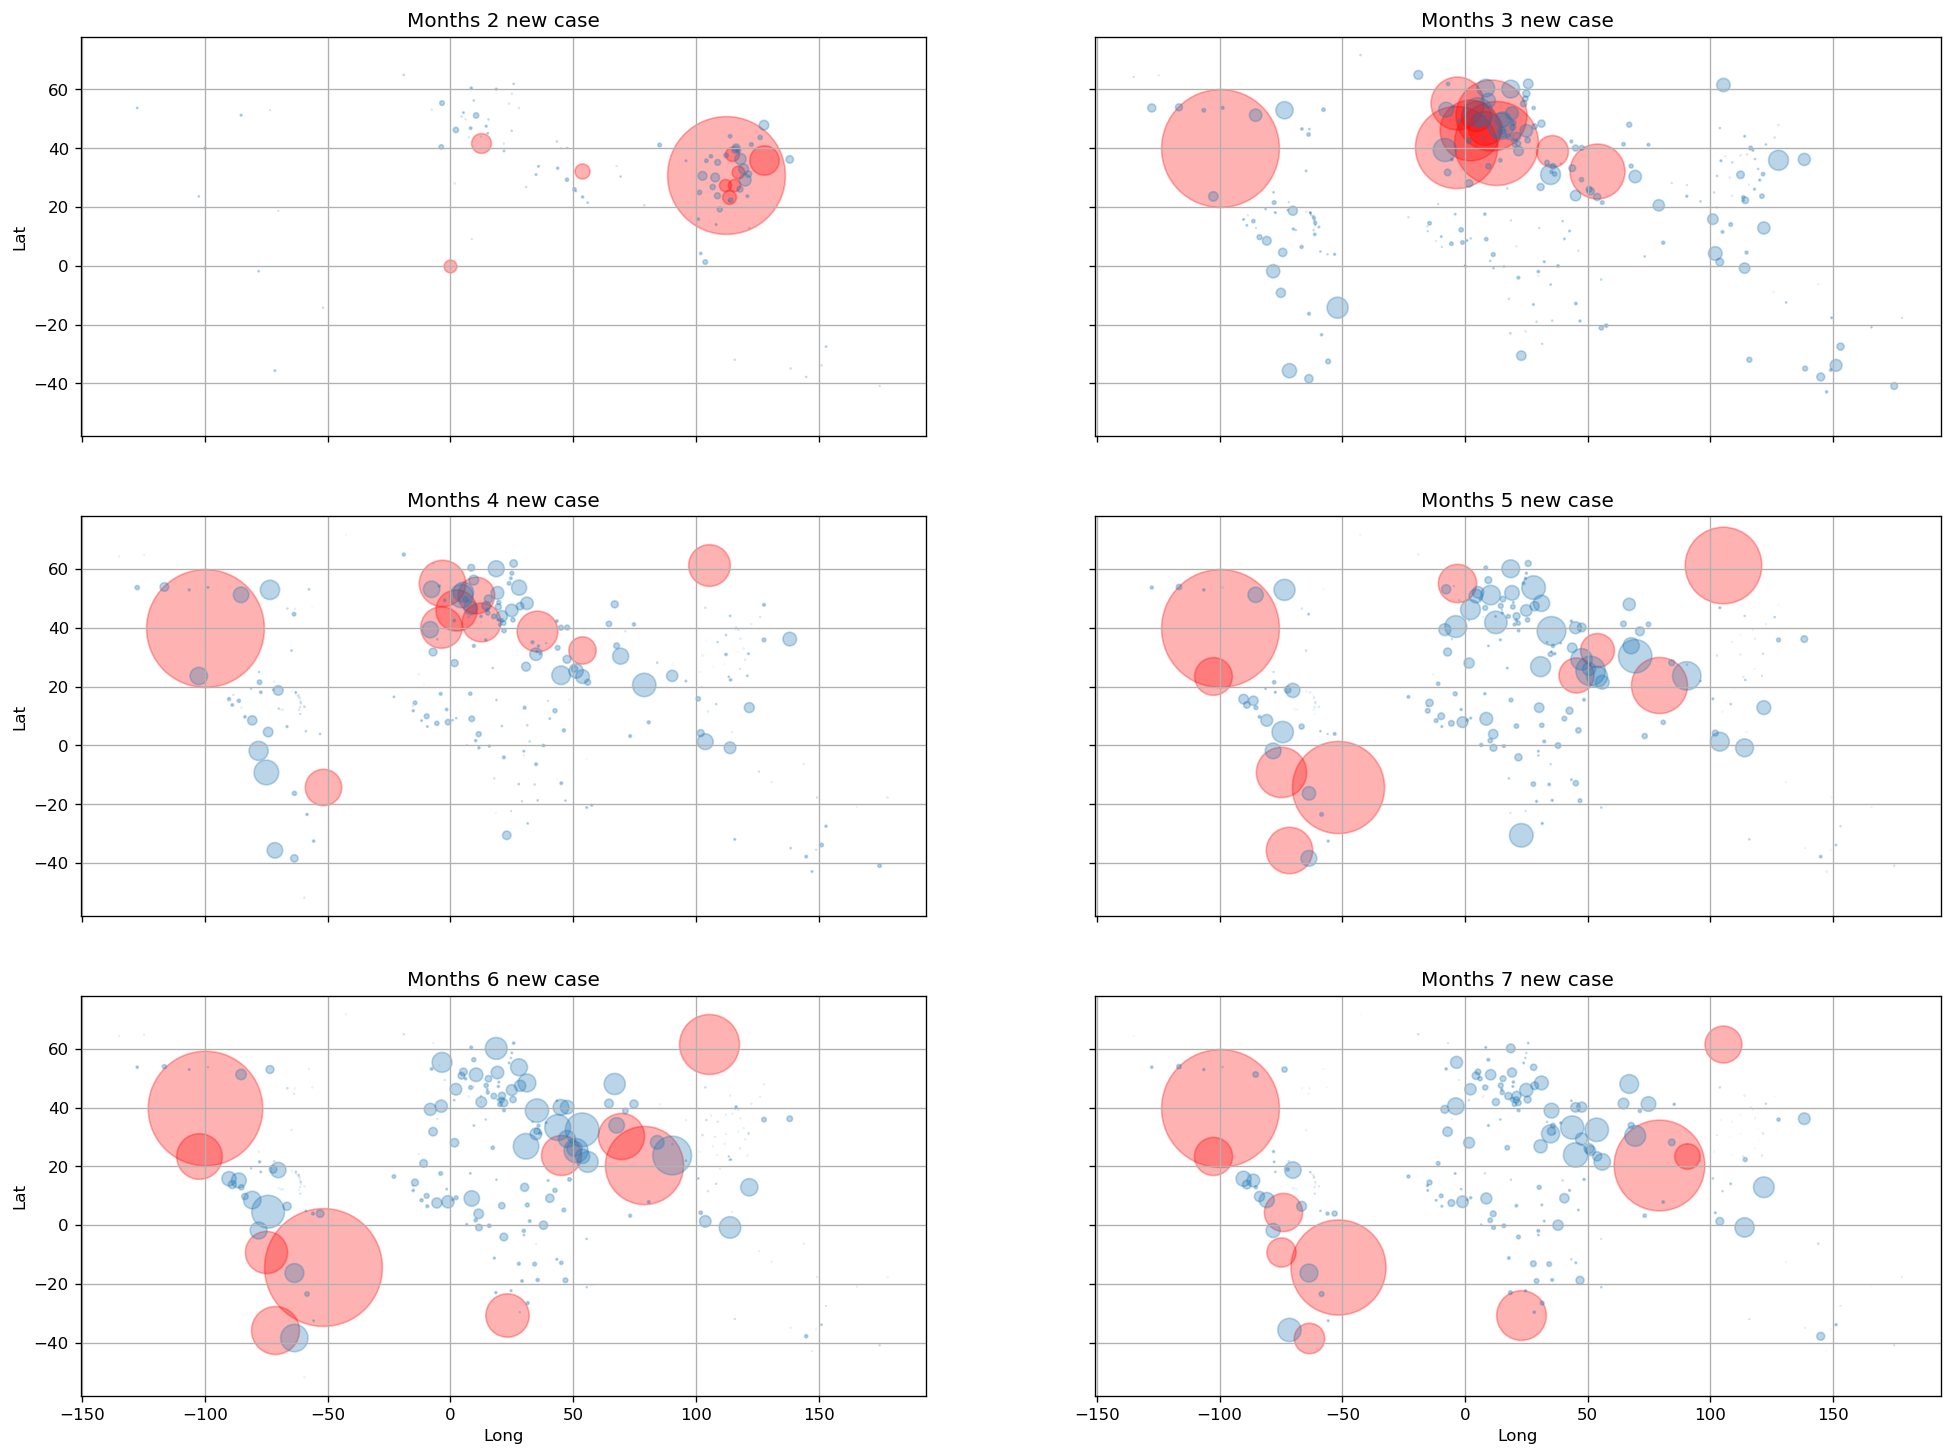

In [53]:
m = 3
latest_day = f"{m}/1/20"
day = f"{m-1}/1/20"

data_2 = data.copy()

fig, axs = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)

m = 3
for i in range(3):
    for j in range(2):
        latest_day = f"{m}/1/20"
        day = f"{m-1}/1/20"
        
        
        ax = axs[i, j]
        ax.set_title(f"Months {m - 1} new case")
        data_2["New case"] = data_2[latest_day] - data_2[day]
        # c = data["Country/Region"] == "Vietnam"

        s = data_2["New case"].values
        s = (s - s.min()) / (s.max() - s.min()) * 5000
#        new_case.plot.scatter("Long", "Lat", s = s, ax=ax, alpha=0.3);

        idxs = data_2.nlargest(10, "New case").index    
        top10 = []
        for idx in idxs:
            name = data["Province/State"][idx]
            if type(name) == type(1.0):
                name = ""
            name += "  " + data["Country/Region"][idx]
            top10.append(name)
            ax.scatter(data["Long"][idx], data["Lat"][idx], label=name, s = s[idx], alpha=0.3, c='r')
        m += 1
        
        other_idxs = list(set(data_2.index) - set(idxs))
        other = data_2.iloc[other_idxs]
        other.plot.scatter("Long", "Lat", s = s[other_idxs], ax=ax, alpha=0.3)
        
        ax.grid()

# Dùng công cụ Tableau để phân tích

## Sử dụng Tableau để Trực quan hóa dữ liệu trên tập dữ liệu covid_19_data.csv đã được tiền xử lí (Data_preprocessed.csv)

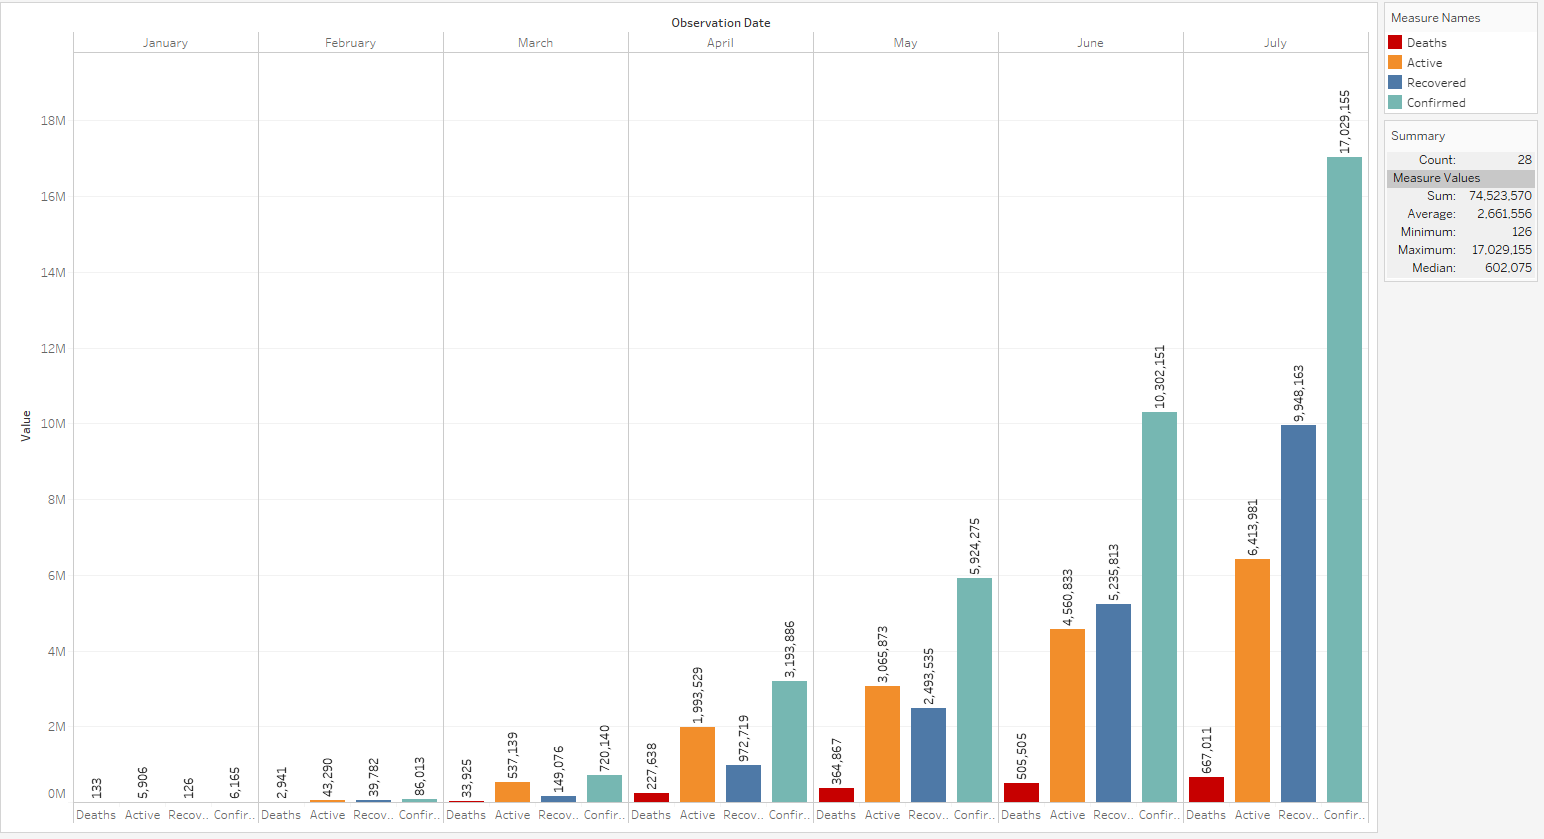

#### Nhận xét:
- Tốc độ tăng của số ca bệnh (Confirmed Cases) vẫn tăng và tăng mạnh, không có dấu hiệu dừng lại
- Tốc độ tăng của số ca Confirmed trong tháng 7 là cao nhất (gần 200,000 ca)
- Tốc độ tăng của số ca tử vong (Deaths) không có biến đổi nhiều qua các tháng

### Biểu đồ thể hiện tỉ lệ % của số ca hiện tại(Active), số ca đã khỏi(Recovered), số ca tử vong (Deaths) so với tất cả số ca được ghi nhận (Confirmed)

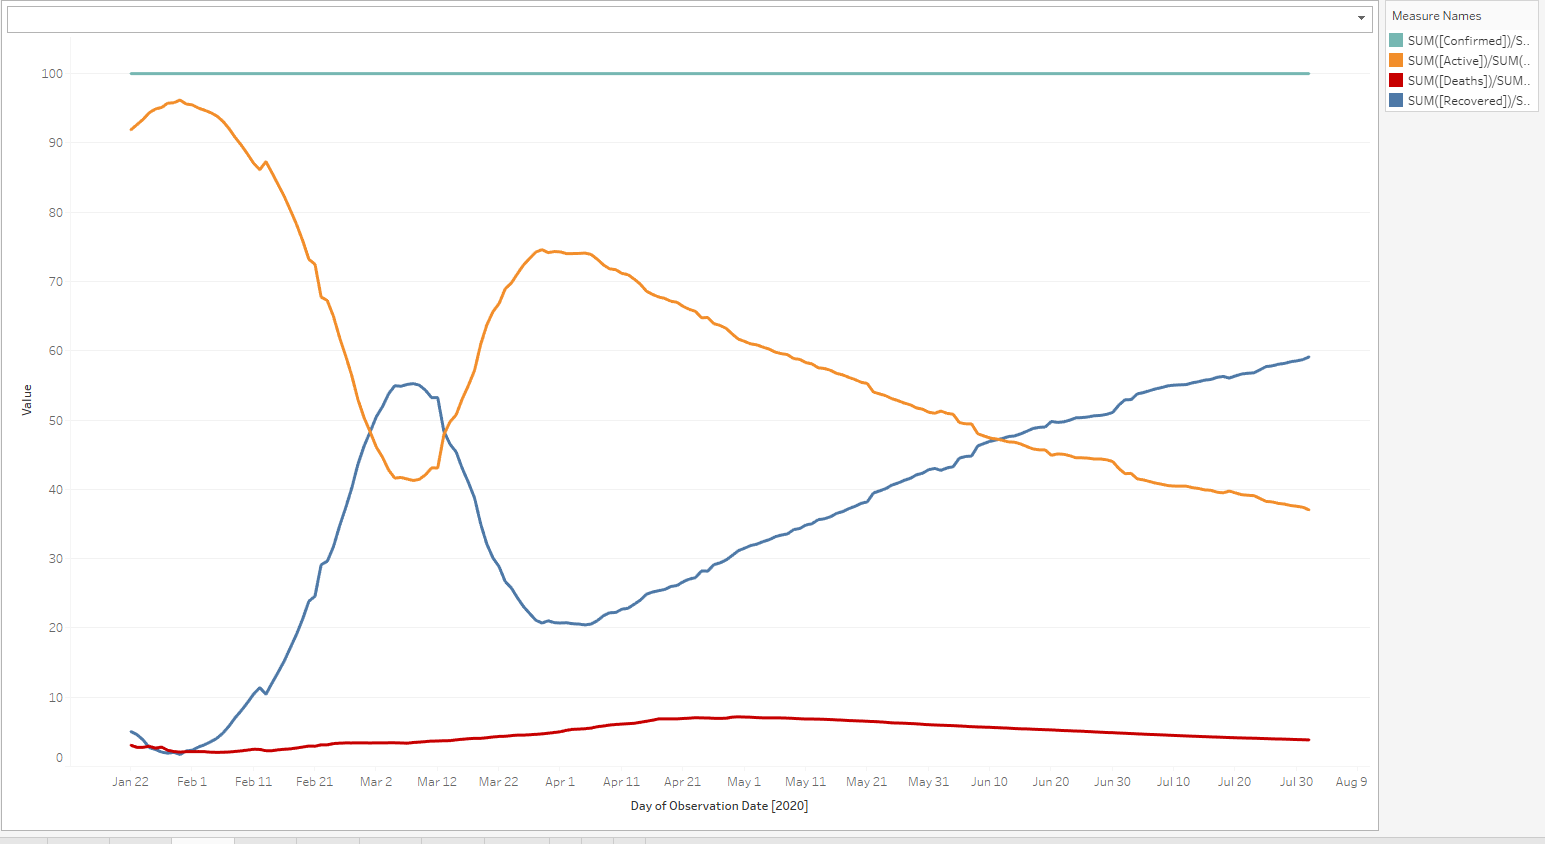

##### Nhận xét:
- Diễn biến về tỉ lệ số ca chết theo thời gian không có thay đổi nhiều
- Active Cases và Recorvered Cases có tương quan trái ngược nhau
- Khoảng thời gian giữa tháng 4 là khoảng thời gian có số ca Active tăng lên, có thể hiểu do khoảng thời gian này đang là đỉnh dịch trên toàn cầu

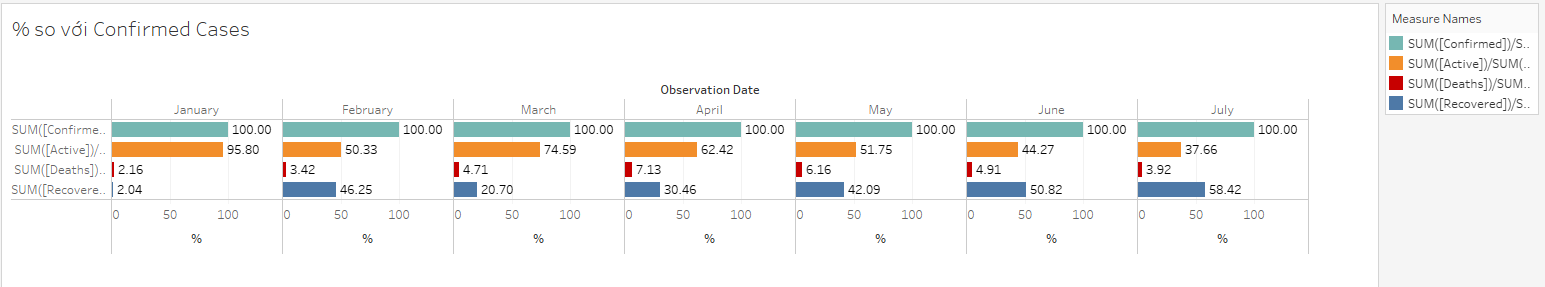

- Mặc dù lượng người chết tăng, tuy nhiên tỉ lệ người chết so với Confirmed Cases có xu hướng giảm sau tháng 4
- Tỉ lệ phục hồi/số ca nhiễm tăng theo thời gian

$\rightarrow$ Theo thời gian thì tỉ lệ số người chết giảm và tỉ lệ phục hồi sẽ tăng

## Italy

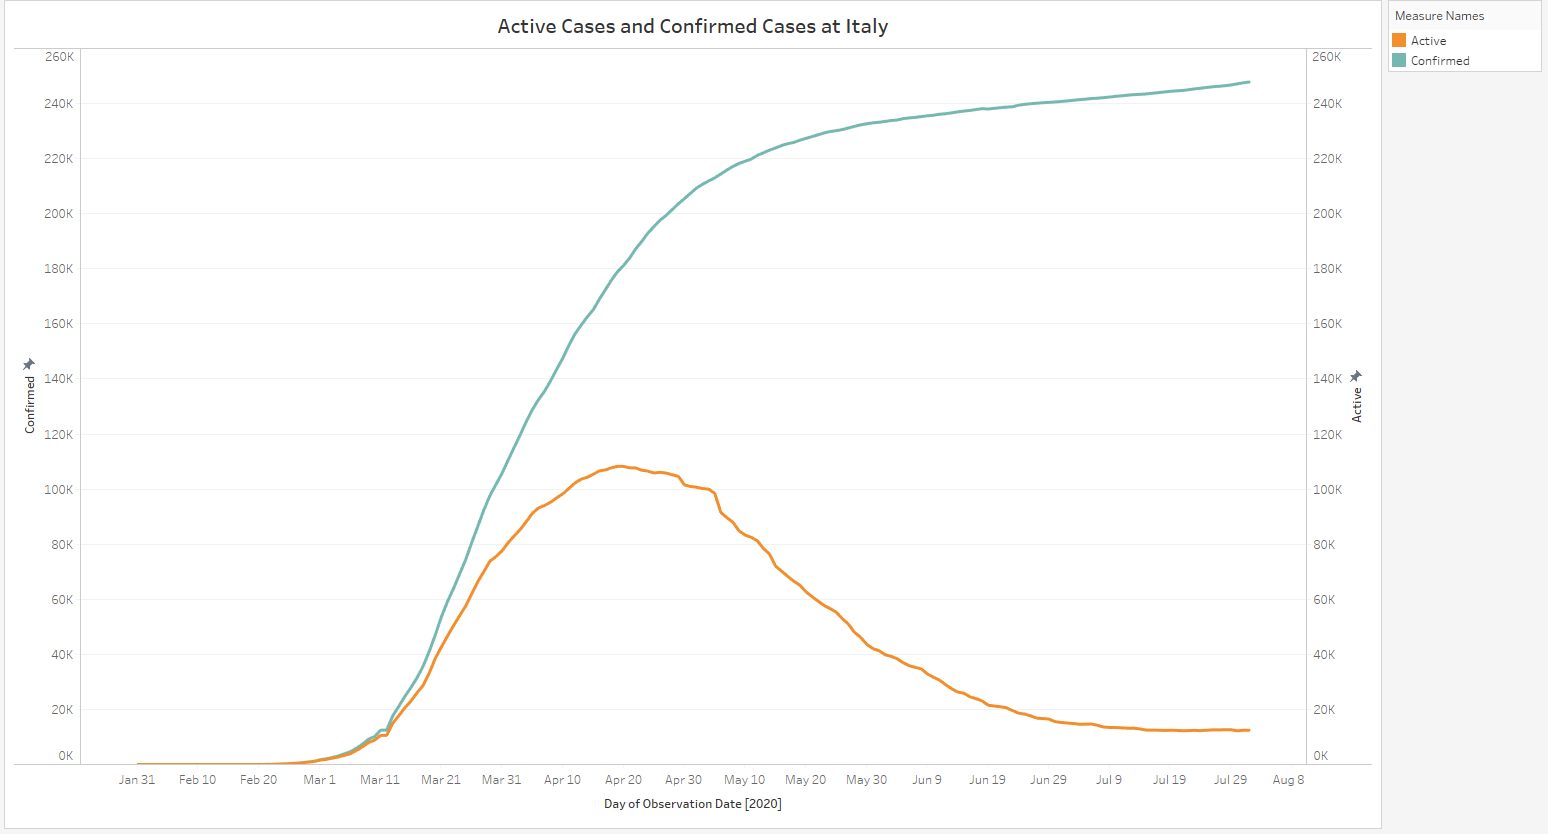

#### Nhận xét:
- Từ biểu đồ đường về số ca hiện tại và tổng số ca mắc tại Ý, ta có thể thấy số ca nhiễm hiện tại có xu hướng giảm so với tổng số ca mắc có xu hướng giảm theo thời gian
- Điều này có thể do chính quyền Ý chính sách chống dịch của Trung Quốc, phong tỏa một số thành phố lớn

https://tuoitre.vn/y-ap-dung-phuong-phap-chong-dich-covid-19-cua-trung-quoc-20200309095658766.htm

## US

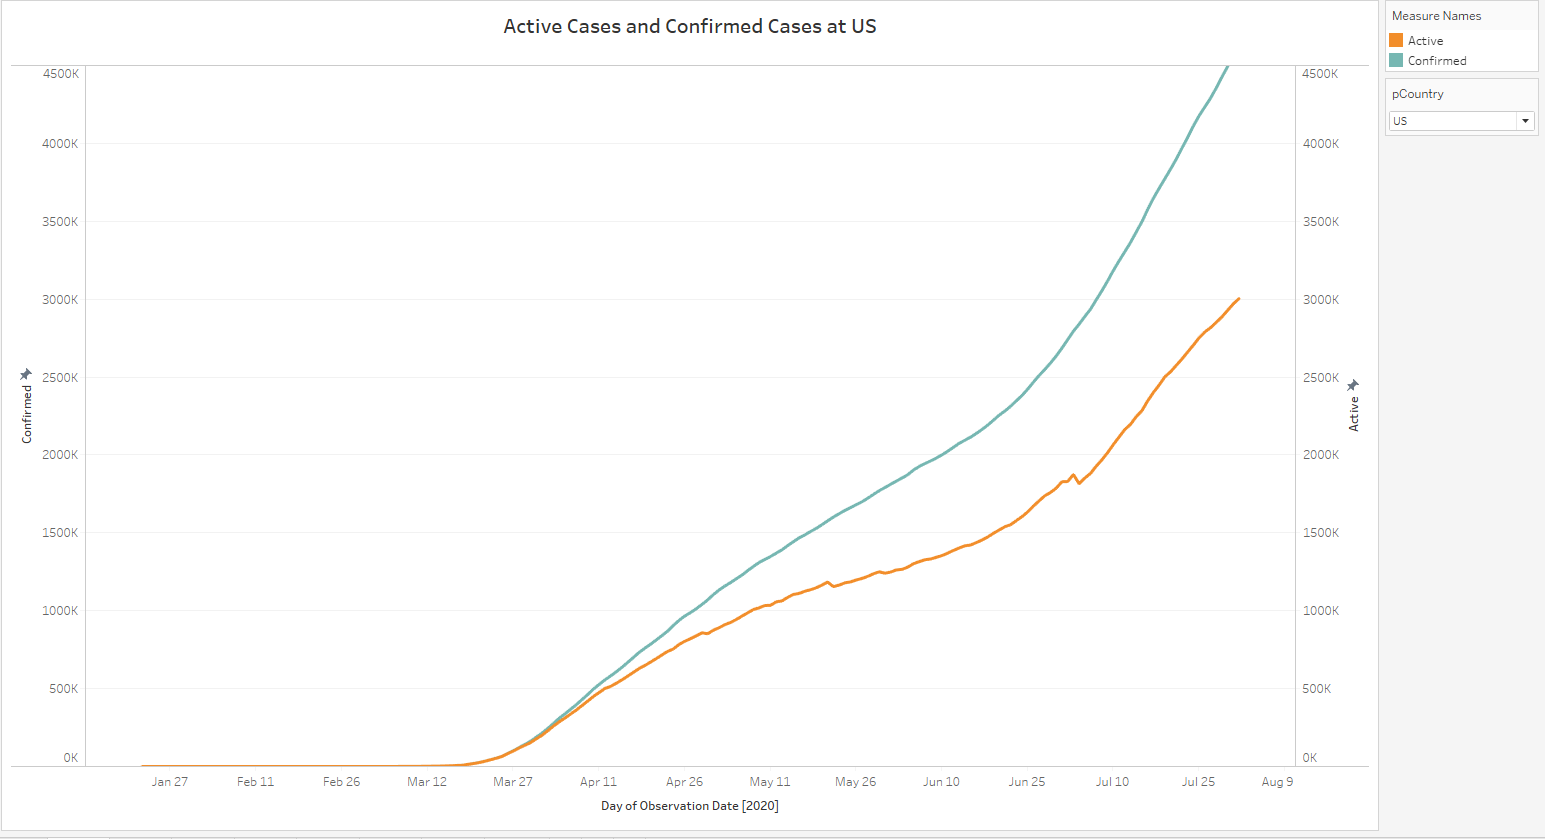

#### Nhận xét:
- Số ca dương tính hiện tại so với tổng số ca nhiễm ở Mỹ theo thời gian không có dấu hiệu giảm.
- Điều này có thể do số ca nhiễm nhiều dẫn đến quá tải ở các bệnh viện hoặc nơi chữa trị

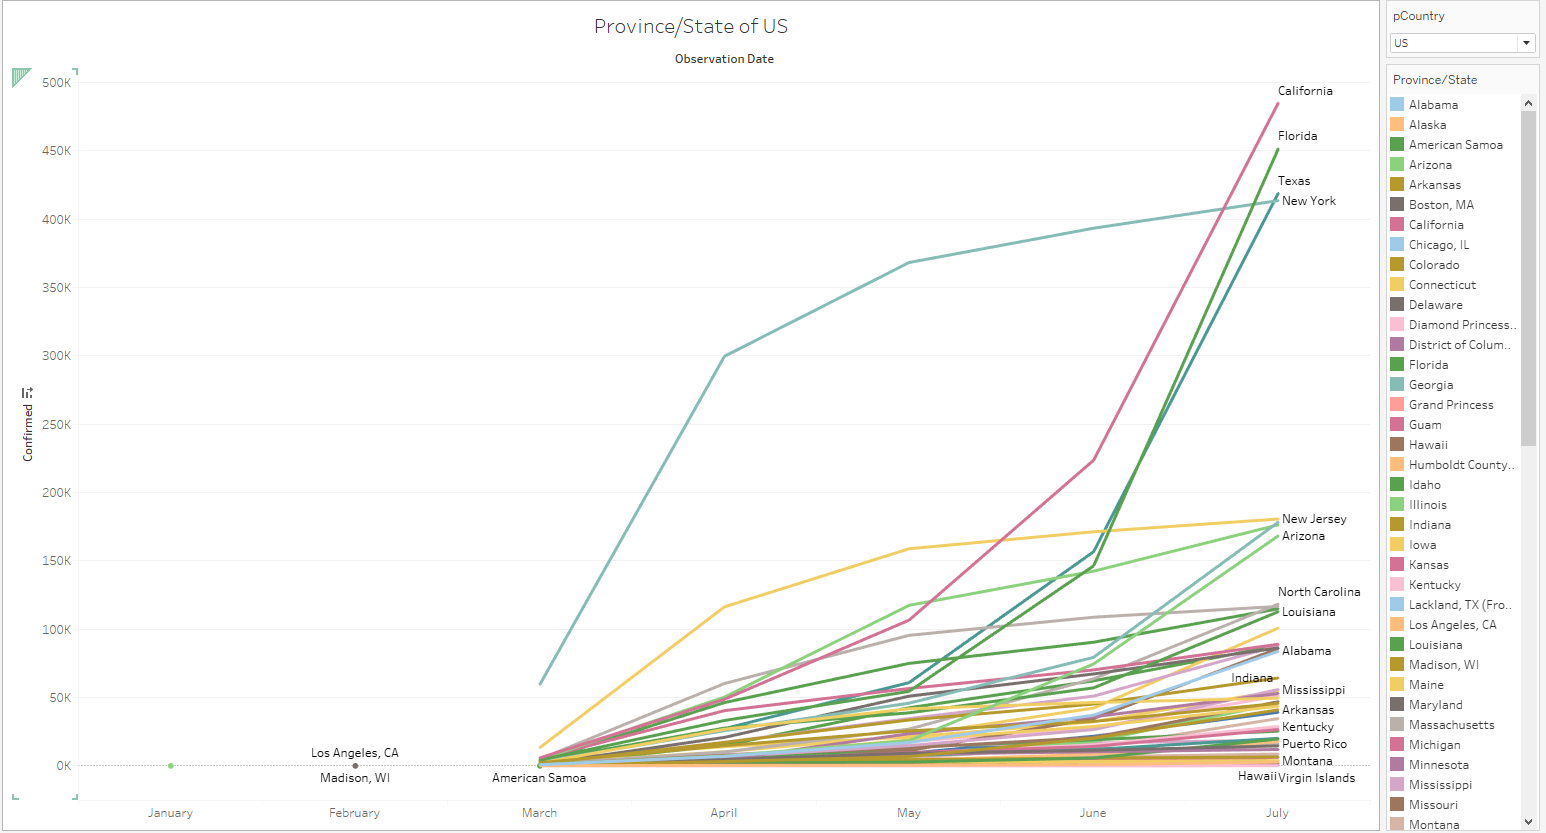

#### Nhận xét:
- Thời gian bùng phát dịch ở Mỹ là khoảng từ tháng 3 trở đi
- New York vẫn là một trong số điểm nóng của dịch nhưng có tốc độ tăng tong 3 tháng (May, Jun, Jul) thấp hơn so với 2 tháng trước đó
- California, Florida, Texas là các khu vực có tốc độ tăng cao nhất nước Mỹ

## China

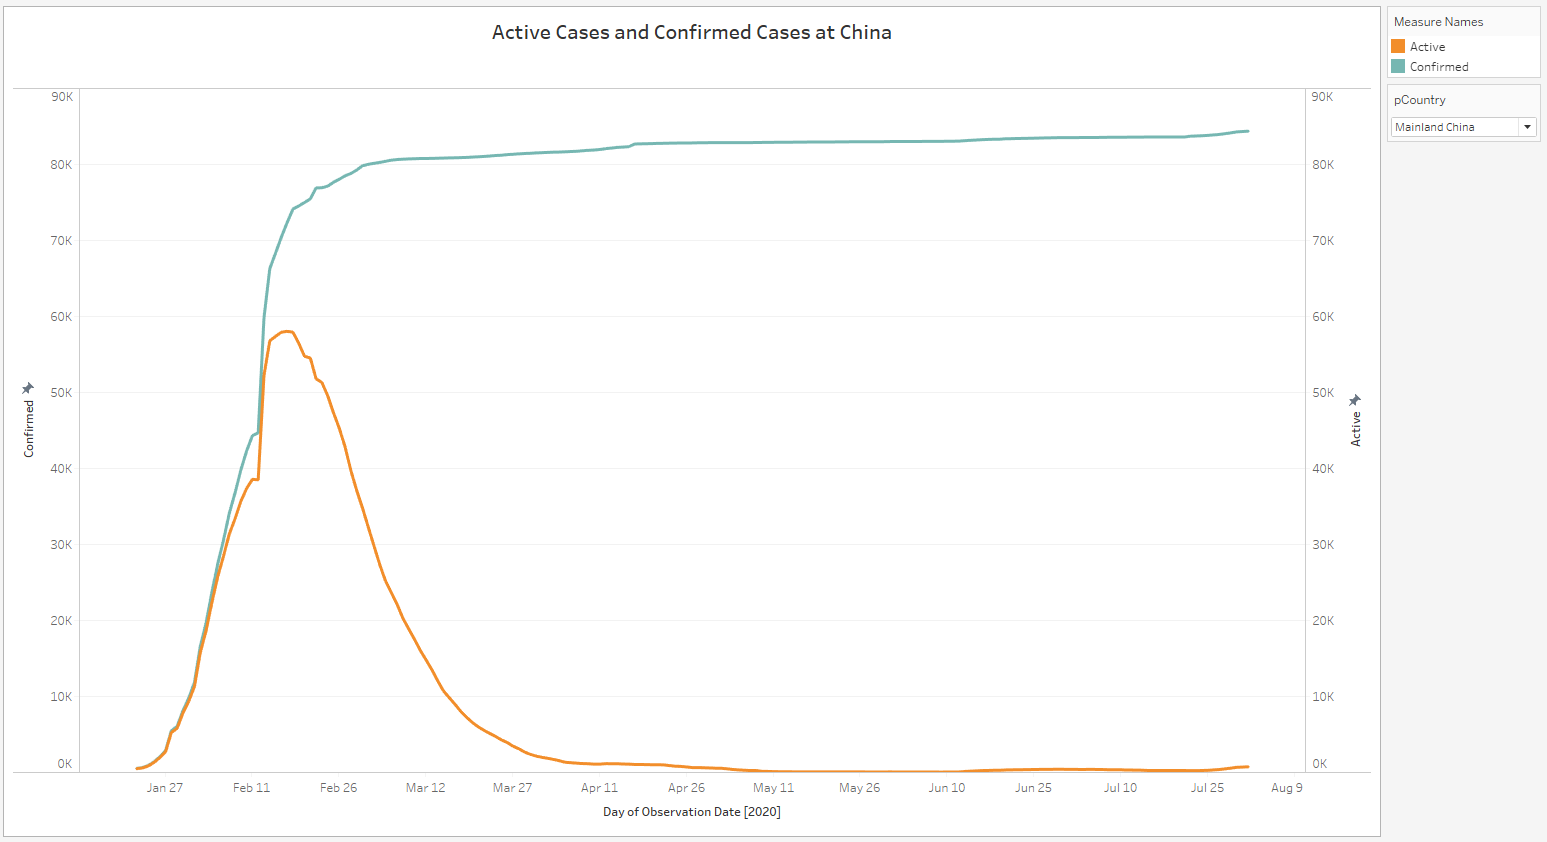

#### Nhận xét:
- Từ tháng 3 trở đi tốc độ tăng số ca nhiễm mới ở TQ có dấu hiệu giảm, tăng chưa đến 10,000 ca bệnh trong thời gian 5 tháng (từ đầu tháng 3 đến hết tháng 7)
- Điều này có khả năng do TQ đã tìm được phát đồ điều trị, chính sách giãn cách xã hội, 1 số biện pháp y tế: đeo khẩu trang, rửa tay thường xuyên

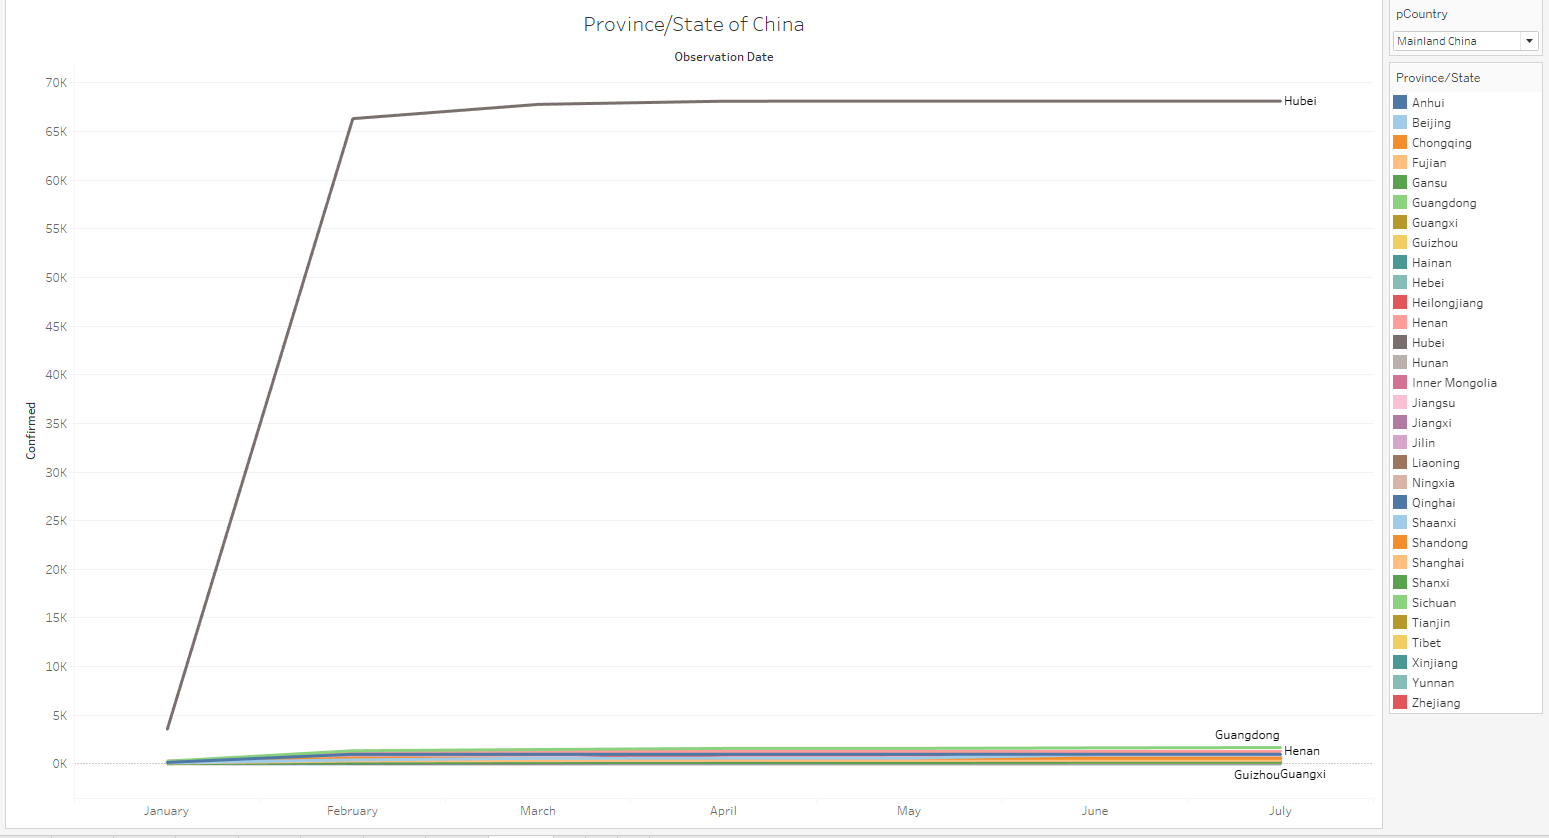

#### Nhận xét:
- Sau đợt bùng phát dịch hồi tháng 2, các số liệu đang chứng tỏ Trung QUốc đang chống dịch rất tốt, dẫn chứng là tốc độ tăng của số ca nhiễm đang rất thấp kể từ tháng 2
- Tổng số ca nhiễm từ tháng 3 đến tháng 8 năm 2020 ít hơn 5000 ca

## Russia

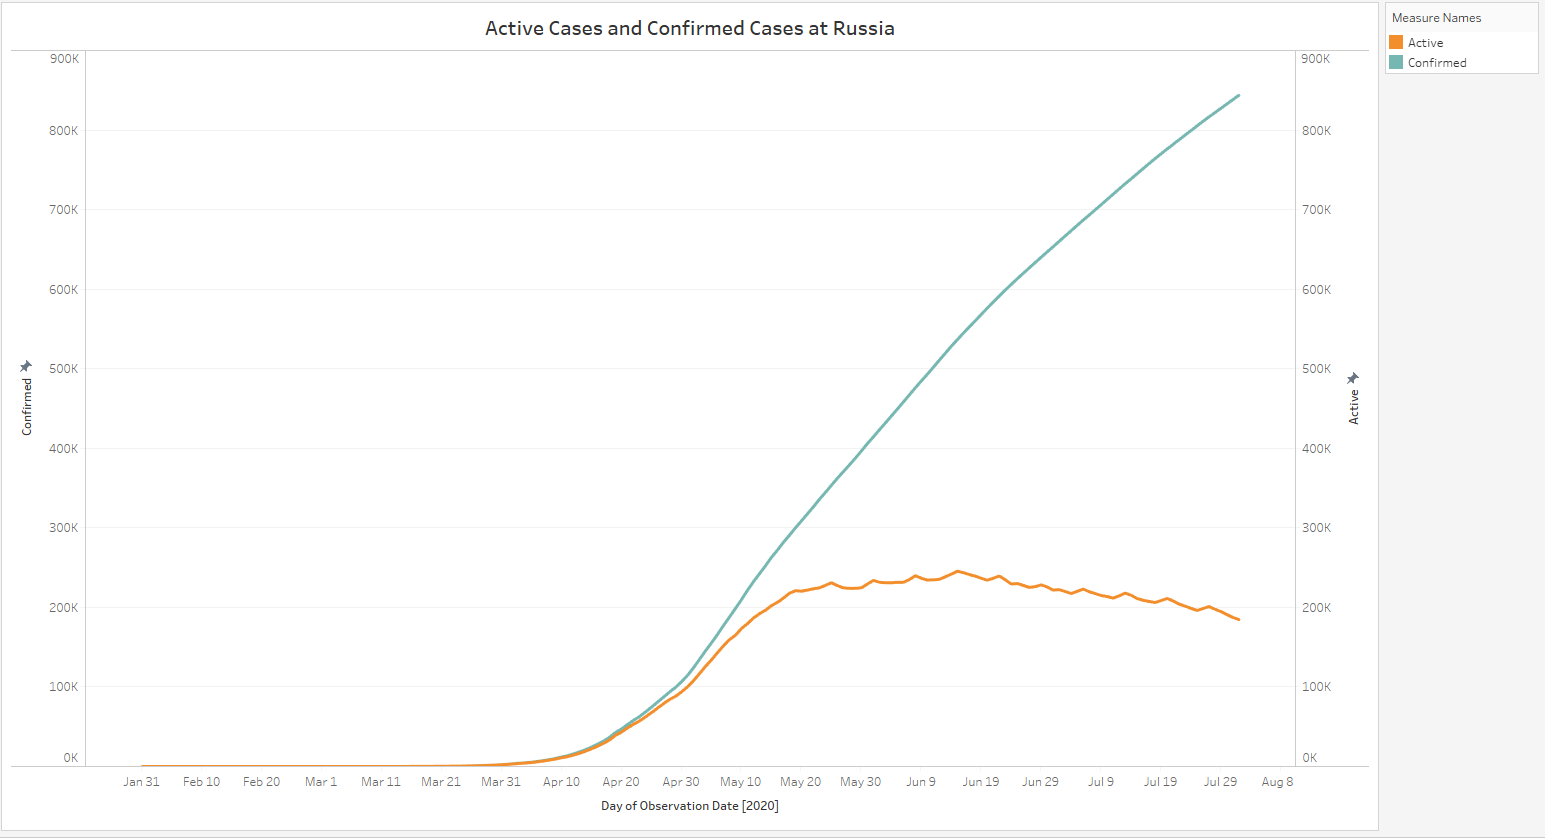

#### Nhận xét:
- Số ca nhiễm bệnh hiện tại có xu hướng giảm, tuy nhiên tốc độ gia tăng số người nhiễm vẫn đang rất cao

# ScatterPlot

# Feb
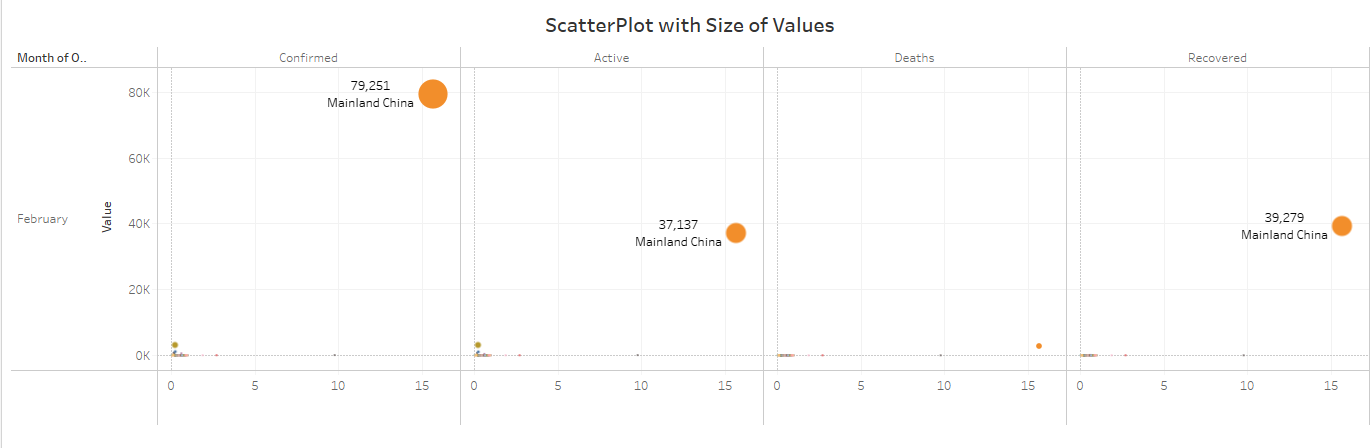

#### Nhận xét:
- Ở thời điểm dịch bắt đầu, China là nước có số ca nhiễm cao nhất và cao hơn tất cả các nước khác

# Mar

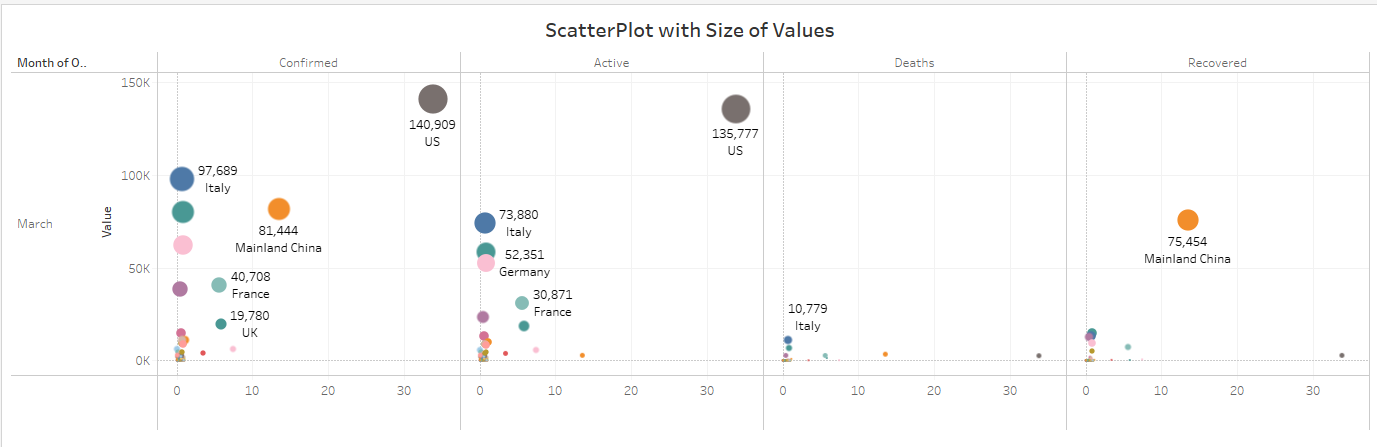

#### Nhận xét:
- Sau 1 tháng, vì Trung Quốc áp dụng những biện pháp an toàn, người dân thực hiện các quy định phòng, chống dịch
nên số ca nhiễm tăng lên rất ít
- Ngược lại, Italy, US, Germany, France có số ca nhiễm tăng rất mạnh
- Recovered của China tăng cao
- Số ca tử vong ở Italy (Deaths) tăng rất cao, lí do có thể là do quá tải và dân số già ở Italy

# Apr
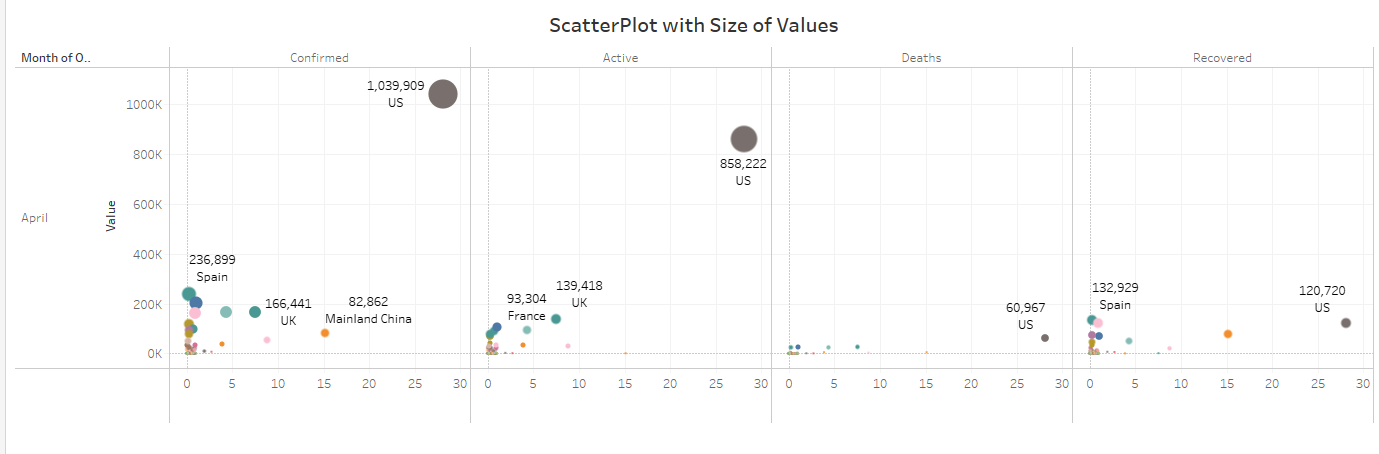

#### Nhận xét:
    - Italy áp dụng 1 số biện pháp như đóng cửa thành phố, đóng cửa các nơi tụ tập đông người nên mức gia tăng không còn cao nữa
    - Trung Quốc vẫn không có sự gia tăng đáng kể
    - Mỹ có sự gia tăng đột ngột cao, điều này chứng tỏ bởi độ dốc của đồ thị đường (lineplot) của Mỹ(ở trên) ở tháng 4 có độ dốc tăng

# May
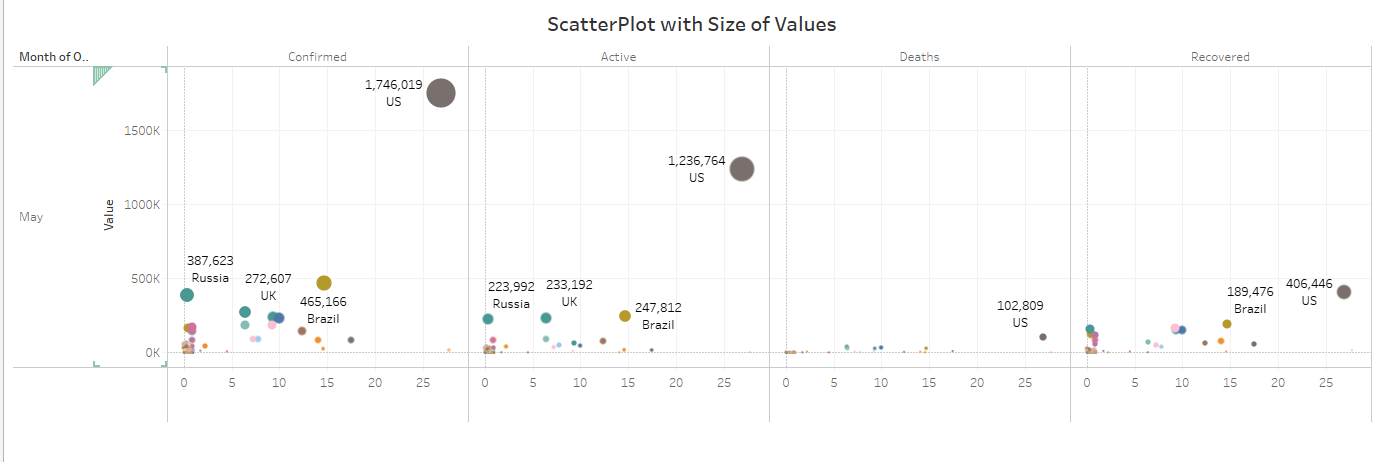

#### Nhận xét:
    - Số ca hồi phục ở US có dấu hiệu tăng
    - Russia là và Brazil là 2 nước đang có số ca nhiễm tăng cao

# Jun
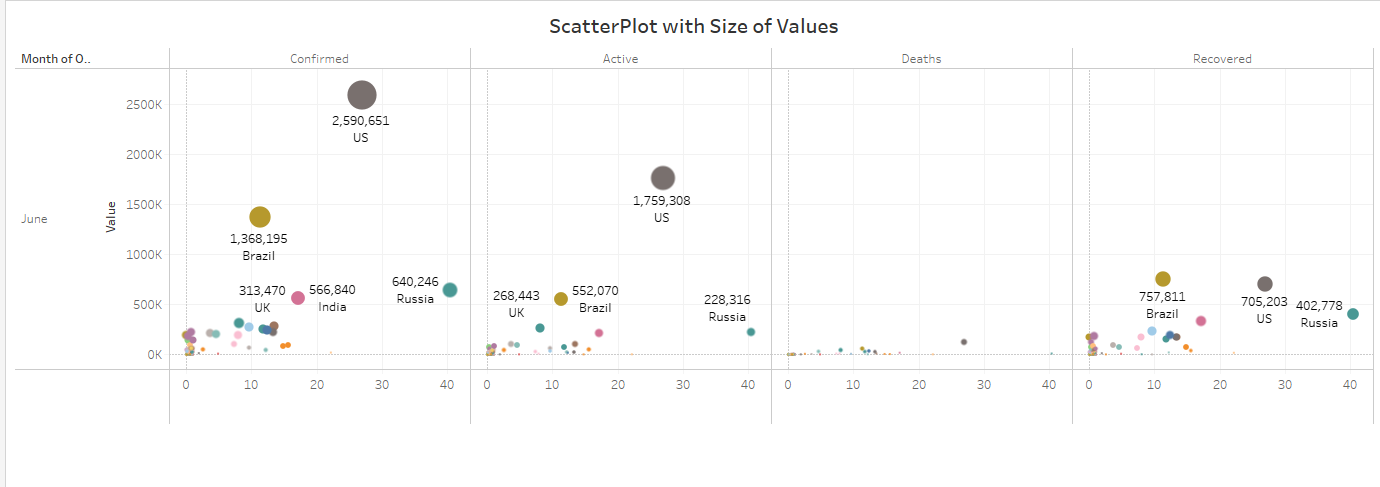

#### Nhận xét:
    - India có số lượng ca nhiễm tăng
    - Số ca hồi phục ở Brazil tăng

# Jul
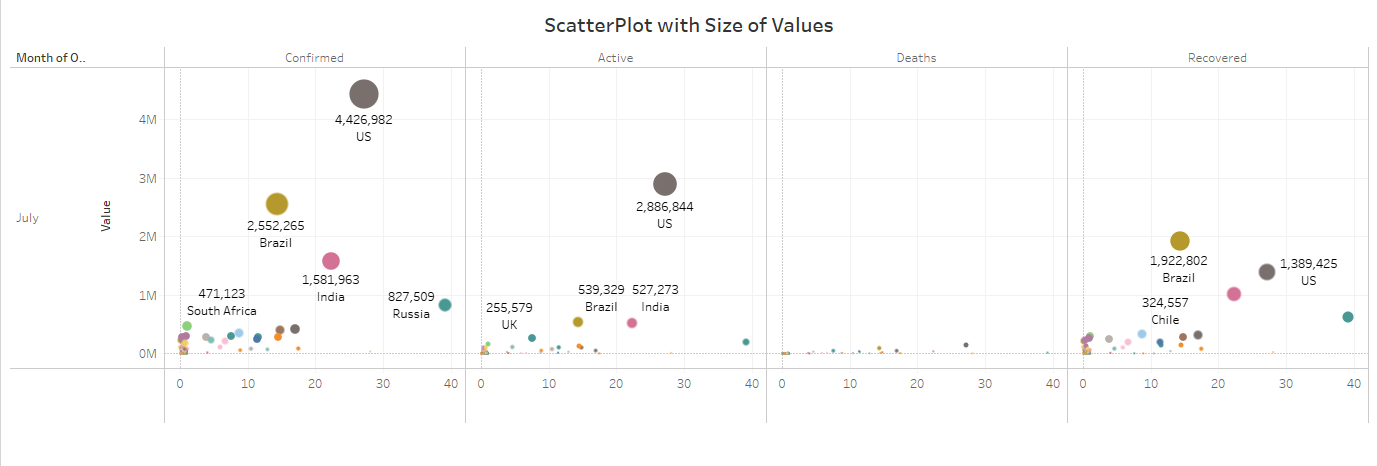

#### Nhận xét:
- Brazil có số ca tăng đột biến
- South Africa cũng có số lượng ca nhiễm tăng
- Số ca hồi phục ở Brazil tăng

# Demo race bar chart for Confirmed Cases
https://public.flourish.studio/visualisation/3468378/

# Các triệu chứng

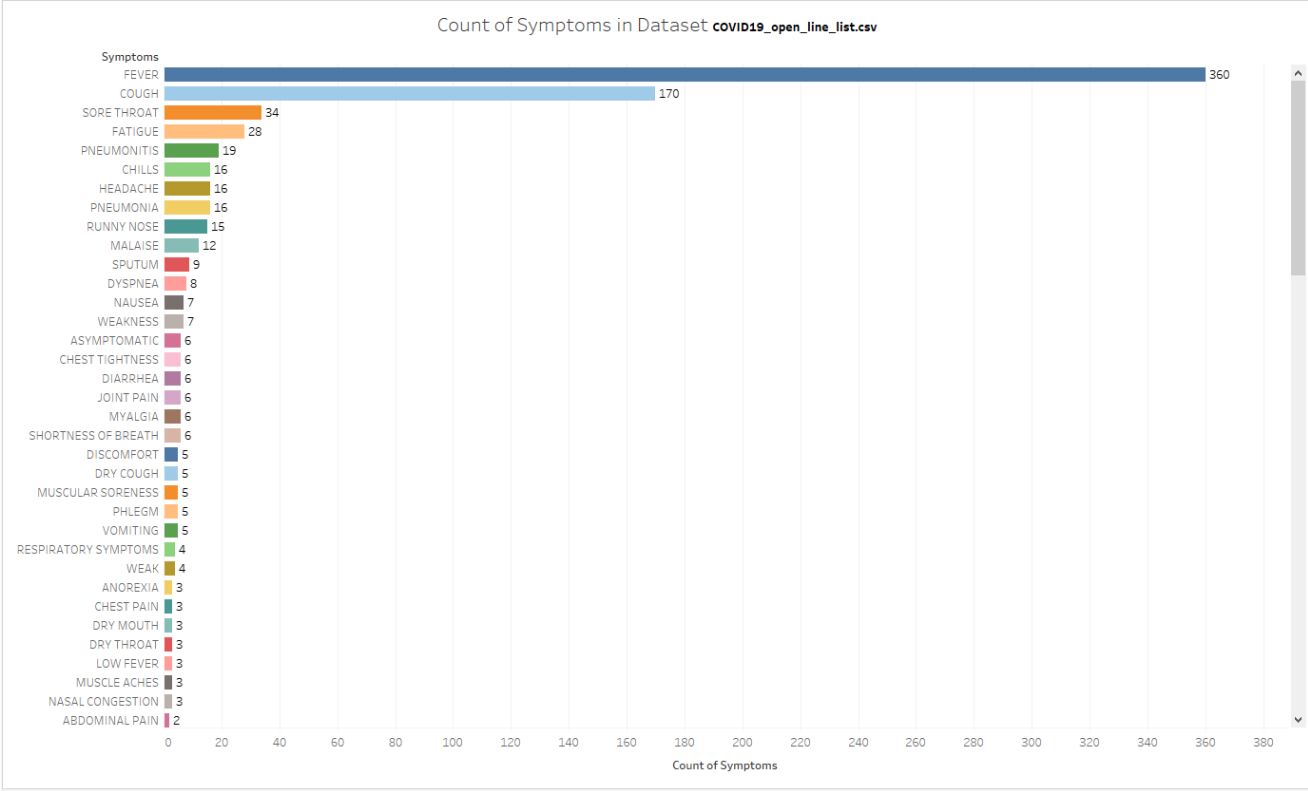

Biểu đồ được vẽ trên bộ dữ liệu: *COVID19_open_line_list.csv* với những mẫu dữ liệu mà thuộc tính **symptoms** không khuyết (gồm 493 mẫu)
#### Nhận xét:
- Triệu chứng phổ biến nhất là sốt và ho
- Trên những mẫu dữ liệu được ghi nhận, hầu hết các trường hợp bệnh đều có triệu chứng **Sốt**
- Tỉ lệ số người có triệu chứng Ho là không lớn
- Một số triệu chứng như Ớn lạnh(Chills), Mệt mỏi(Fatigue), Đau đầu(Headache) khá thấp

# Tuổi

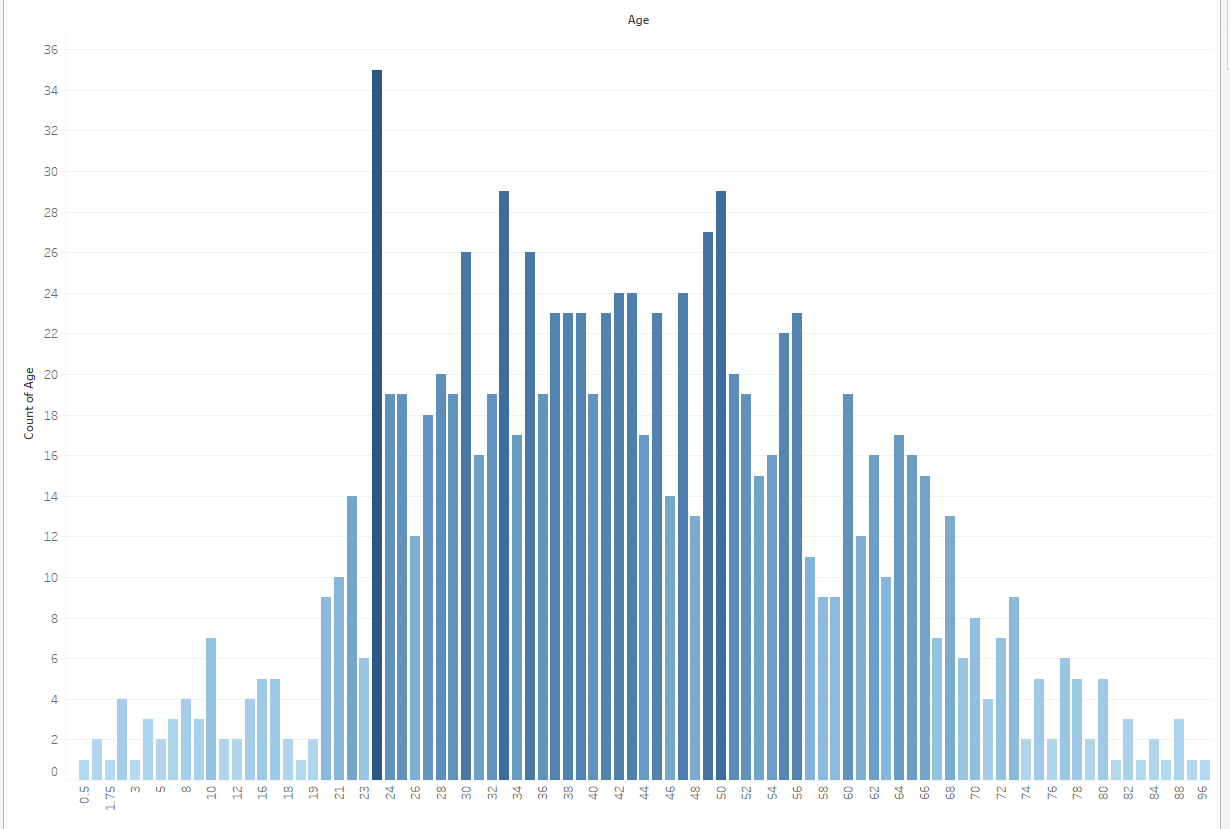

Biểu đồ được vẽ trên bộ dữ liệu: *COVID19_open_line_list.csv* vỡi những mẫu dữ liệu mà thuộc tính Age không khuyết (1349 mẫu)
#### Nhận xét:
- Ta có thể thấy đa số nhóm người được ghi nhận có độ tuổi đa dạng
- Độ tuổi tập trung nhiều ở khoảng [25,55]